# Training decoder with held subset of data - dimension_wise

On each dimension (1-proportion_train_partition) data is held out.

E.g., there are 16 x positions for the Gaussian. If proportion_train_partition is 0.8, then 13 of this 16 (13=round(0.8 * 16)) positions are part of the training set, the remaining 3 are part of the validation set.

For the tested proportions, .2, .4, .6, .8, 1., this amounts to

- 0.2: pow(.2,4) = 0.16% of all training samples
- 0.4: pow(.4,4) = 2.56% of all training samples
- 0.6: pow(.6,4) = 12.96% of all training samples
- 0.8: pow(.6,4) = 40.96% of all training samples



In [296]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch.nn import MSELoss

import os

from torchvision import transforms

from models.decoders import decoderBVAE_like_wElu_SigmoidOutput

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesb import dSpriteBackgroundDataset

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [30]:
proportion_train_partition = np.array([1., .8, .6, .4, .2])

In [31]:
model = list()
training_stats = list()
partition = list()
datasets_train = list()
datasets_validation = list()

for ii,prop in enumerate(proportion_train_partition):

    model.append(decoderBVAE_like_wElu_SigmoidOutput().to(device))
    model[ii].eval()
    
    checkpoint = torch.load('trained/decoderbvae_like_welu_sigmoidoutput_dsprites_circle_trainPartitionProportion={}_dimwise_last_200K'.format(prop))
    model[ii].load_state_dict(checkpoint['model_states']['net'])

    training_stats.append(pickle.load(open('trained/decoderbvae_like_welu_sigmoidoutput_dsprites_circle_trainPartitionProportion={}_dimwise_200K.pkl'.format(prop), 'rb')))

    partition.append(torch.load(open('trained/decoderbvae_like_welu_sigmoidoutput_dsprites_circle_trainPartitionProportion={}_dimwise_partition_200K'.format(prop), 'rb')))
    
    datasets_train.append(dSpriteBackgroundDataset(partition[ii]['train'],transform=transforms.Resize((32,32)),
                                            shapetype = 'circle'))
    datasets_validation.append(dSpriteBackgroundDataset(partition[ii]['validation'],transform=transforms.Resize((32,32)),
                                            shapetype = 'circle'))

In [32]:
for ii,prop in enumerate(proportion_train_partition):
    print('for prop = {}'.format(prop))
    print('  train      - latents_values.shape: {}'.format(datasets_train[ii].latents_values.shape))
    print('  validation - latents_values.shape: {}'.format(datasets_validation[ii].latents_values.shape))


for prop = 1.0
  train      - latents_values.shape: (262144, 4)
  validation - latents_values.shape: (0, 4)
for prop = 0.8
  train      - latents_values.shape: (114244, 4)
  validation - latents_values.shape: (147900, 4)
for prop = 0.6
  train      - latents_values.shape: (36100, 4)
  validation - latents_values.shape: (226044, 4)
for prop = 0.4
  train      - latents_values.shape: (6084, 4)
  validation - latents_values.shape: (256060, 4)
for prop = 0.2
  train      - latents_values.shape: (324, 4)
  validation - latents_values.shape: (261820, 4)


### plot training loss

[None, Text(0, 0.5, 'log loss'), Text(0.5, 0, '# of batches')]

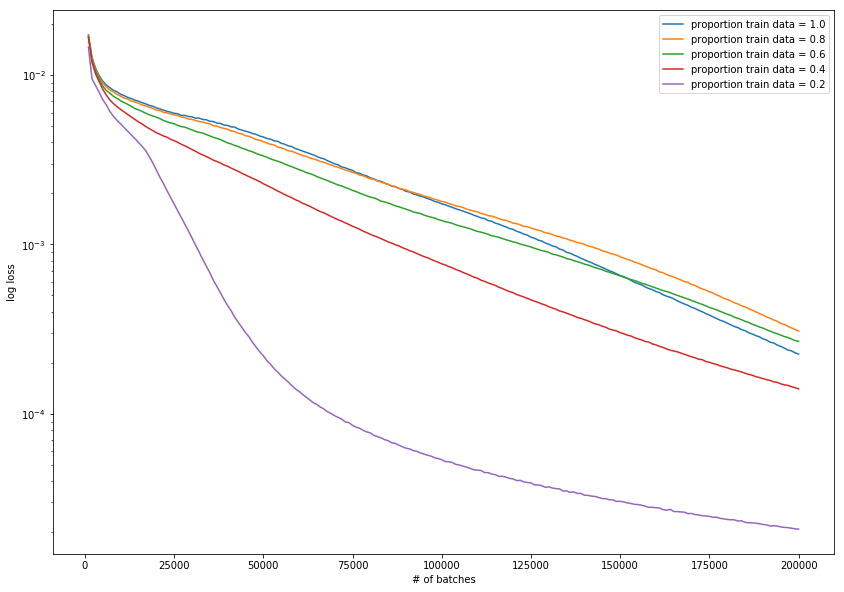

In [33]:
fig, ax = plt.subplots(1,1,sharey=False,sharex=True, figsize=(14,10))

for ii,prop in enumerate(proportion_train_partition):
    ax.plot(training_stats[ii]['iter'], training_stats[ii]['recon_loss'], label='proportion train data = {}'.format(prop))

ax.legend()
ax.set(yscale='log', ylabel='log loss', xlabel='# of batches')


## Visualization

In [34]:
n_grid = 8

x = np.linspace(-.5, 1.5, n_grid)
y = np.linspace(-.5, 1.5, n_grid)

xv, yv = np.meshgrid(x,y, sparse = False)

### Sweeping through latent space for model with 100% training data

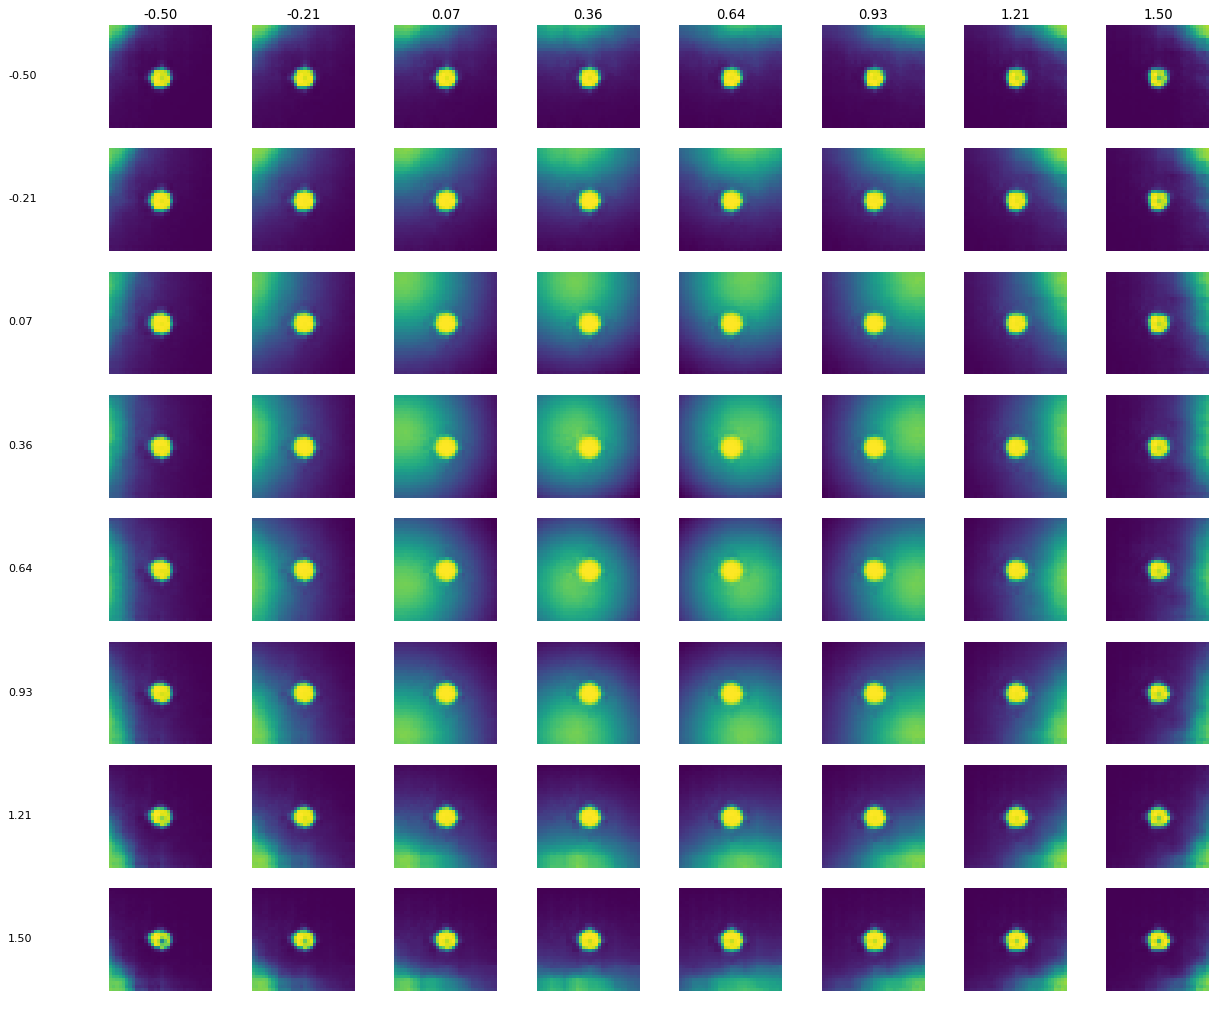

In [35]:
modIdx = 0

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

latents = torch.Tensor(1,4).to(device)
latents[0, :2] = torch.Tensor([.5, .5])
for ii in range(n_grid):
    for jj in range(n_grid):
        latents[0, 2:] = torch.Tensor([xv[ii,jj], yv[ii,jj]])
        
        plt.subplot(n_grid, n_grid, ii*n_grid + jj + 1)
        plt.imshow(model[modIdx](latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        if ii == 0:
            plt.title('%0.2f' % y[jj])
        if jj == 0:
            plt.text(-32, 16, '%0.2f' % x[ii])      

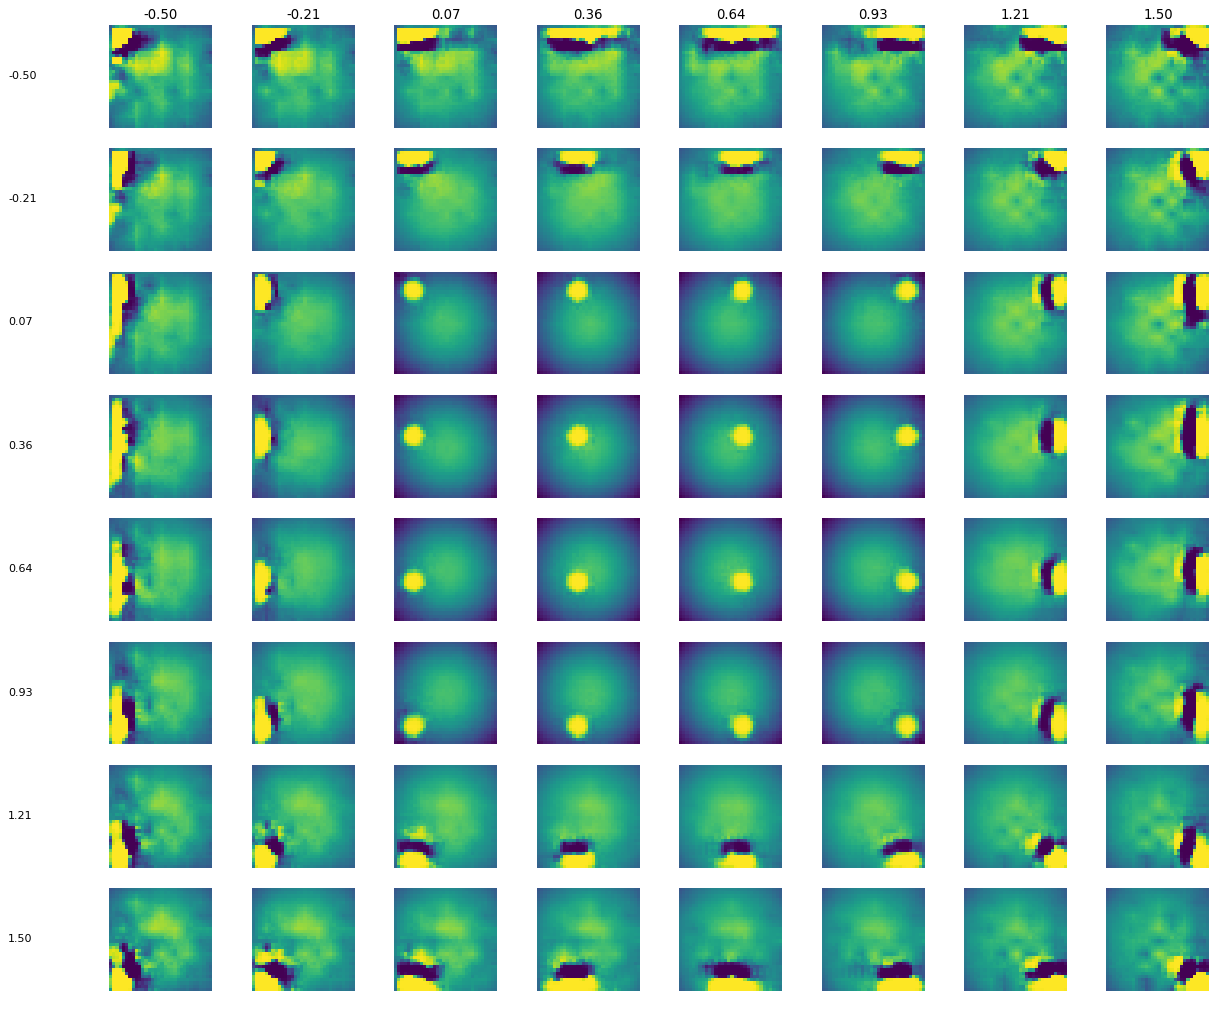

In [36]:
modIdx = 0

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

latents = torch.Tensor(1,4).to(device)
latents[0, 2:] = torch.Tensor([.5, .5])
for ii in range(n_grid):
    for jj in range(n_grid):
        latents[0, :2] = torch.Tensor([xv[ii,jj], yv[ii,jj]])
        
        plt.subplot(n_grid, n_grid, ii*n_grid + jj + 1)
        plt.imshow(model[modIdx](latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        if ii == 0:
            plt.title('%0.2f' % y[jj])
        if jj == 0:
            plt.text(-32, 16, '%0.2f' % x[ii])

### Sweeping through latent space for model with 20% data dimensions as training (~ 0.16% of all samples)

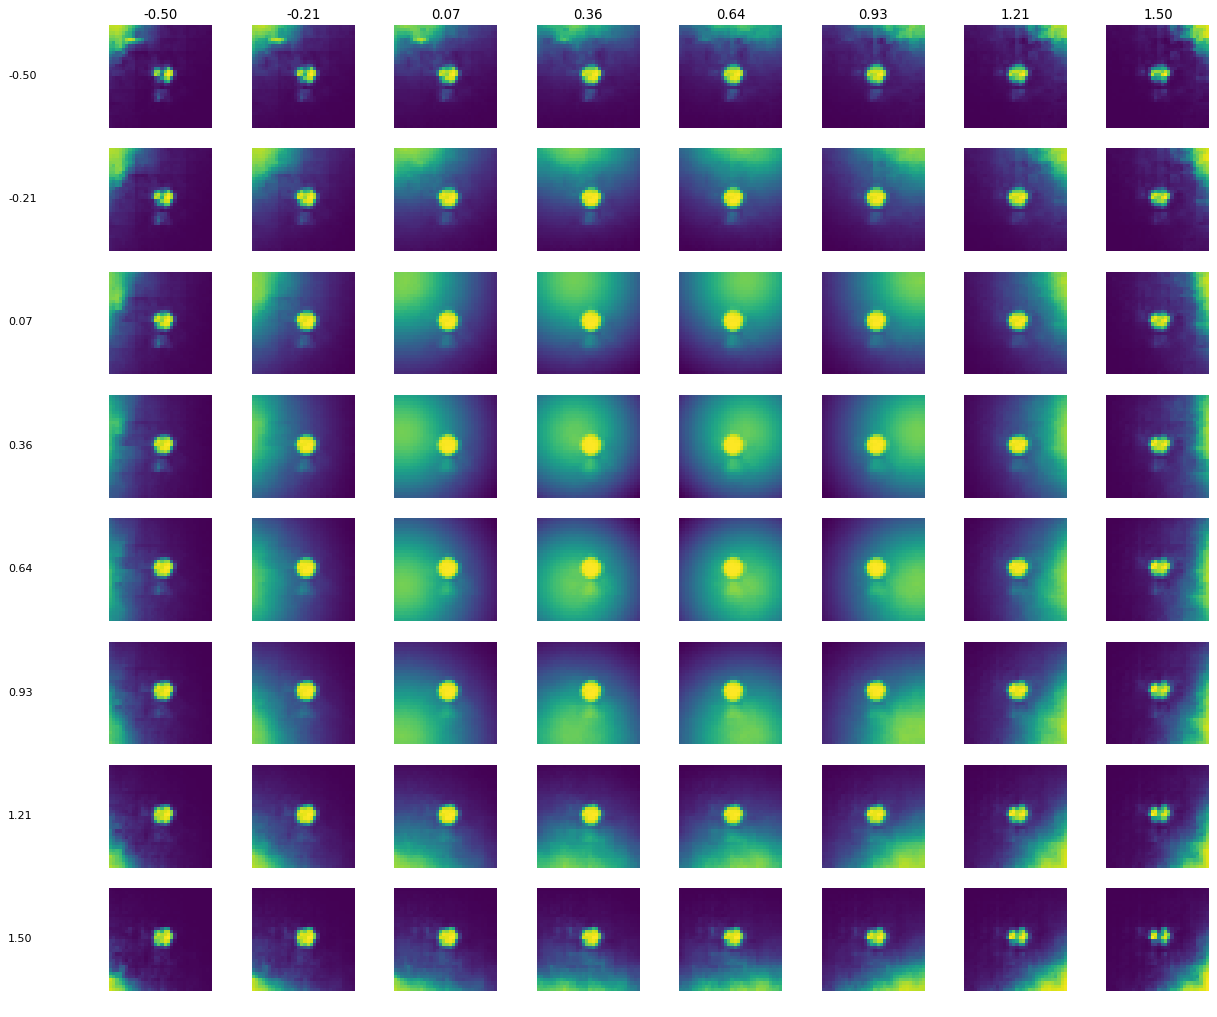

In [37]:
modIdx = 4

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

latents = torch.Tensor(1,4).to(device)
latents[0, :2] = torch.Tensor([.5, .5])
for ii in range(n_grid):
    for jj in range(n_grid):
        latents[0, 2:] = torch.Tensor([xv[ii,jj], yv[ii,jj]])
        
        plt.subplot(n_grid, n_grid, ii*n_grid + jj + 1)
        plt.imshow(model[modIdx](latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        if ii == 0:
            plt.title('%0.2f' % y[jj])
        if jj == 0:
            plt.text(-32, 16, '%0.2f' % x[ii])      

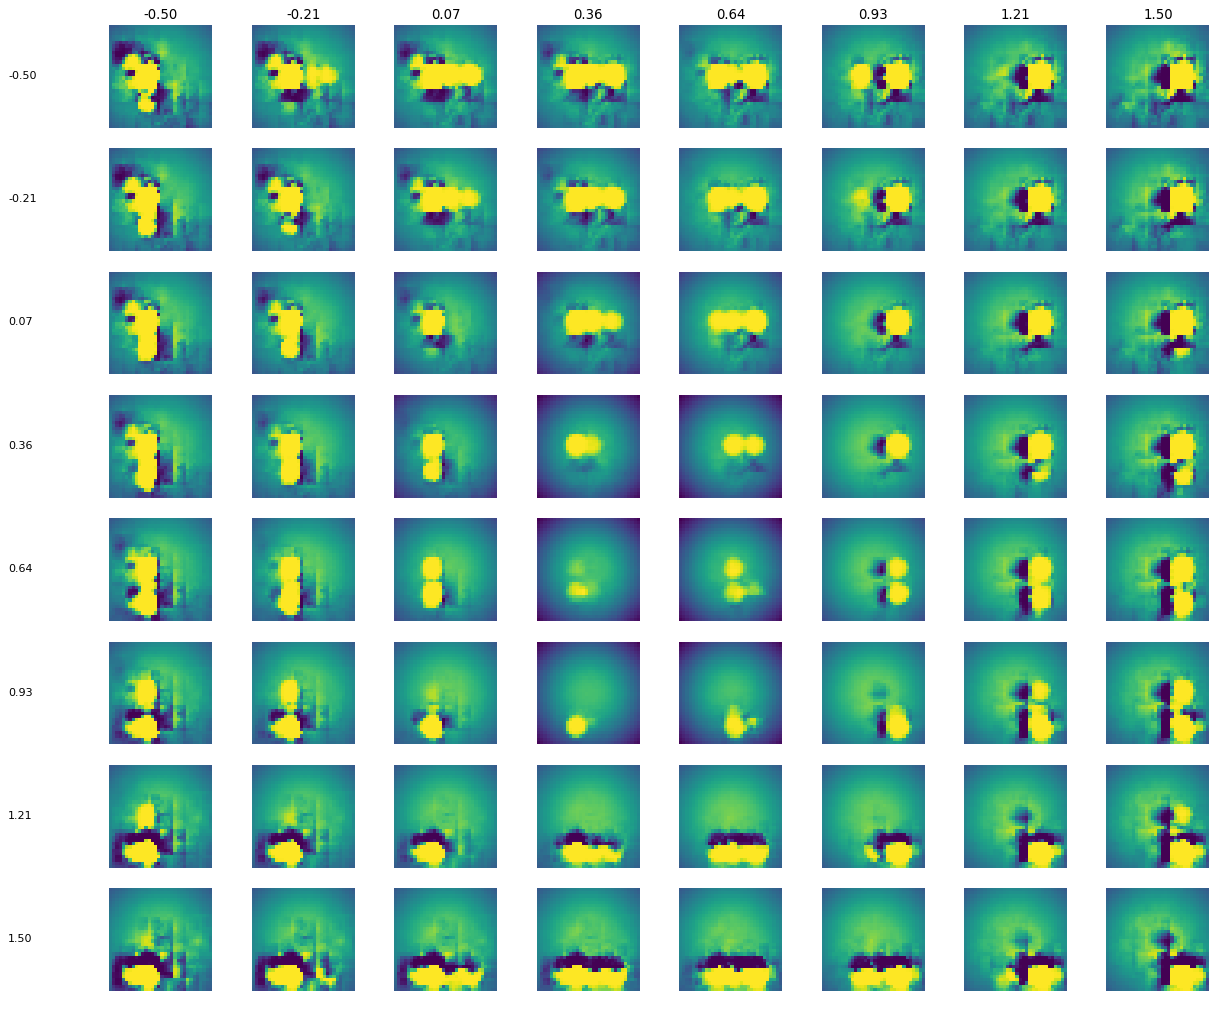

In [38]:
modIdx = 4

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

latents = torch.Tensor(1,4).to(device)
latents[0, 2:] = torch.Tensor([.5, .5])
for ii in range(n_grid):
    for jj in range(n_grid):
        latents[0, :2] = torch.Tensor([xv[ii,jj], yv[ii,jj]])
        
        plt.subplot(n_grid, n_grid, ii*n_grid + jj + 1)
        plt.imshow(model[modIdx](latents).detach().cpu().numpy().squeeze())
        plt.axis('off')
        if ii == 0:
            plt.title('%0.2f' % y[jj])
        if jj == 0:
            plt.text(-32, 16, '%0.2f' % x[ii])

## Loss in training vs validation set

for each of the trained proportions, compute reconstruction error for training and validation set

In [39]:
loss = MSELoss()

dataloaderparams = {'batch_size': 64,
                    'shuffle': False,
                    'num_workers': 6}


train_loss = np.zeros(len(proportion_train_partition))
validation_loss = np.zeros(len(proportion_train_partition))
train_iter = np.zeros(len(proportion_train_partition))
validation_iter = np.zeros(len(proportion_train_partition))

for ii,_ in enumerate(model):

    data_loader = torch.utils.data.DataLoader(datasets_train[ii], **dataloaderparams)
    for [samples, latents] in data_loader:
        img_batch, code_batch = samples.to(device), latents.to(device)
        predicted_batch = model[ii](code_batch)
        actLoss = loss(predicted_batch, img_batch)

        train_loss[ii] += actLoss.item()/dataloaderparams['batch_size']
        train_iter[ii] += 1.


    data_loader = torch.utils.data.DataLoader(datasets_validation[ii], **dataloaderparams)
    for [samples, latents] in data_loader:
        img_batch, code_batch = samples.to(device), latents.to(device)
        predicted_batch = model[ii](code_batch)
        actLoss = loss(predicted_batch, img_batch)

        validation_loss[ii] += actLoss.item()/dataloaderparams['batch_size']
        validation_iter[ii] += 1.

/home/benjamin/anaconda3/envs/deepl10/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'loss training vs validation')

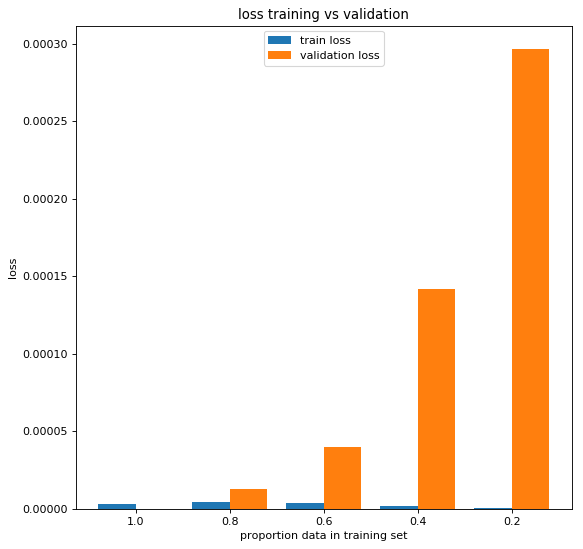

In [40]:
fig,ax=plt.subplots(1,1,figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')

ax.bar(2*np.arange(0,len(proportion_train_partition))-.4,  train_loss/train_iter, label='train loss')
ax.bar(2*np.arange(0,len(proportion_train_partition))+.4,  validation_loss/validation_iter, label='validation loss')

ax.set(xticks=2*np.arange(0,len(proportion_train_partition)), xticklabels=(proportion_train_partition))
ax.set(ylabel='loss', xlabel='proportion data in training set')
ax.legend()

plt.title('loss training vs validation')


#### (a series of helper functions needed for subsequent plotting)

In [338]:
def plotReconstructionLossPerGridPoint(lossPerGridPoint, dimVals, axes, plt_colorbar = False):
    """
    def plotReconstructionLossPerGridPoint(lossPerGridPoint, dimVals, axes, plt_colorbar = False):
        
        plots for each grid point in the circle hyperplane and the gaussian hyperplane in latent space
        the correponding reconstruction error
        
    """    
    mx = np.percentile(lossPerGridPoint, 95)
    mn = np.percentile(lossPerGridPoint, 5)

    im = axes[0].imshow(np.mean(lossPerGridPoint, axis = (2,3), keepdims=False), 
                    vmin=mn, vmax = mx,
                   extent = [dimVals[0][0], dimVals[0][-1], dimVals[1][0], dimVals[1][-1]])
    axes[0].set_title('foreground circle')
    im = axes[1].imshow(np.mean(lossPerGridPoint, axis = (0,1), keepdims=False),
                    vmin=mn, vmax = mx,
                   extent = [dimVals[2][0], dimVals[2][-1], dimVals[3][0], dimVals[3][-1]])
    axes[1].set_title('background gaussian')

    if plt_colorbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)


def subSampleTickLabels(ax, x_or_y = 'both',n = 5):
    """
    def subSampleTickLabels(ax, x_or_y = 'both',n = 5):
        
        helper function, subsamples the xticklabels and/or yticklabels (displays only every n-th label)
    
    """
    if x_or_y == 'both':
        doX = True
        doY = True
    elif x_or_y == 'x':
        doX = True
    elif x_or_y == 'y':        
        doY = True
    else:
        pass
    
    if doX:
        for ii,label in enumerate(ax.get_xticklabels()):
            if np.mod(ii,n) != 0:
                label.set_visible(False)
    if doY:
        for ii,label in enumerate(ax.get_yticklabels()):
            if np.mod(ii,n) != 0:
                label.set_visible(False)

def plotSampledGridPointsForTrainingSet(partition, axes = None, flipy = False):
    """
    def plotSampledGridPointsForTrainingSet(partition, axes = None):
        
        plots a depiction which points in those the circle and gaussian hyperplane were part of the training set.
    
    """
    dimVals = partition['datadimvals']
    trnIdx = partition['dimwise_train_idx']

    if axes is None:
        fig,axes=plt.subplots(1,2,figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
    
    X,Y = np.meshgrid(dimVals[0][trnIdx[0]],dimVals[1][trnIdx[1]])
    axes[0].set(xticks=dimVals[0],yticks=dimVals[1])
    subSampleTickLabels(axes[0])
    axes[0].scatter(X,Y, s=10, facecolors='r')
    axes[0].grid(alpha = 1)
    axes[0].set(title='foreground circle')
    
    X,Y = np.meshgrid(dimVals[2][trnIdx[2]],dimVals[3][trnIdx[3]])
    axes[1].set(xticks=dimVals[2],yticks=dimVals[3])
    subSampleTickLabels(axes[1], n = 2)
    axes[1].scatter(X,Y, s=10, facecolors='r')
    axes[1].grid(alpha = 1)
    axes[1].set(title='background gaussian')
    
    if flipy:
        axes[0].invert_yaxis()
        axes[1].invert_yaxis()
    
    return axes

def plotInterpolatedReconstruction(train_proportion, whichobject = 'circle'):
    """
    def plotInterpolatedReconstruction(train_proportion, whichobject = 'circle'):
        
        for a given train_proportion, interpolates linearly in latent space in the circle hyperplane
        and gaussian hyperplane and plots reconstructed images alongside a depiction which points
        in those hyperplanes were part of the training set.
    
    """
    modIdx = np.where(proportion_train_partition == train_proportion)[0][0]
    dimVals = partition[modIdx]['datadimvals']
    
    if whichobject == 'circle':
        dim1 = 0
        fromto = [3,30]
        axIdx = 0
    elif whichobject == 'gaussian':
        dim1 = 2
        fromto = [1,15]  
        axIdx = 1
    
    # start and endpoints of line
    x1 = dimVals[dim1][fromto]
    y1 = dimVals[dim1+1][fromto]
    
    actPartition = partition[modIdx]

    npoints = 8 
    
    pts_x = x1[0] + np.linspace(0,np.diff(x1),npoints)
    pts_y = y1[0] + np.linspace(0,np.diff(y1),npoints)

    col = plt.cm.viridis(np.linspace(0,1,npoints))

    fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
    gs = fig.add_gridspec(3, 4)
    ax = list()
    ax.append(fig.add_subplot(gs[0, :2]))
    ax.append(fig.add_subplot(gs[0, 2:]))
    ax2 = list()
    for oo in range(1,3):
        for pp in range(4):
            ax2.append(fig.add_subplot(gs[oo, pp]))
            
    plotSampledGridPointsForTrainingSet(actPartition, axes=ax, flipy= True)
    ax[axIdx].plot(x1,y1, color='r')
    ax[axIdx].scatter(pts_x, pts_y, color=col, s= 50)
    

    latents = .5 * torch.ones(1,4).to(device)
    for ii,actAx in enumerate(ax2):
        if whichobject == 'circle':
            latents[0, :2] = torch.Tensor([pts_x[ii][0], pts_y[ii][0]])
        else:
            latents[0, 2:] = torch.Tensor([pts_x[ii][0], pts_y[ii][0]])
        recon = model[modIdx](latents).detach().cpu().numpy().squeeze()
        actAx.imshow(recon)
        actAx.set_title('x={1:.1f},y={1:.1f}'.format(latents[0,0],latents[0,1]), color=col[ii], fontweight='bold')
        actAx.axis('off')

In [ ]:
def computeOrLoadReconstructionErrorPerGridPoint(train_proportion):
    
    modIdx = np.where(proportion_train_partition == train_proportion)[0][0]
    dimVals = partition[modIdx]['datadimvals']


    fpath = 'heldOutDimWiseAnalysis_ReconErrorPerGridPoint.pkl'
    if os.path.isfile(fpath):
        with open(fpath, 'rb') as f:
            reconError = pickle.load(f)
    else: # first time, no file yet.
        reconError = dict()
        with open(fpath, 'wb+') as f:
            pickle.dump(reconError,f)        

    # check if computed already
    if not(train_proportion in reconError):
        # compute lossPerGridPoint 
        lossPerGridPoint = np.zeros([len(x) for _,x in enumerate(dimVals)])
        for ixc, xc in enumerate(dimVals[0]):
            for iyc, yc in enumerate(dimVals[1]):
                for ixg, xg in enumerate(dimVals[2]):
                    for iyg, yg in enumerate(dimVals[3]):
                        latents = torch.Tensor([xc,yc,xg,yg]).to(device)
                        reconstructed = model[modIdx](latents)
                        actual = datasets_train[0].arbitraryCircle(objx=xc,objy=yc,backx=xg,backy=yg).to(device)
                        actLoss = loss(reconstructed, actual)
                        lossPerGridPoint[ixc,iyc,ixg,iyg] = actLoss.item()        
        
        # store results
        with open(fpath, 'wb+') as f:
            reconError[train_proportion] = lossPerGridPoint
            pickle.dump(reconError, f)
            
    return reconError[train_proportion]

for ii,prop in enumerate(proportion_train_partition):
    computeOrLoadReconstructionErrorPerGridPoint(prop)

## Reconstruction loss as a function of latent space grid position

Plot reconstruction error for each grid point, or rather: for each grid point on the two hyperplanes for circle and gaussian. The remaining (not displayed) dimensions are averaged.

- top two plots: reconstruction error (color coded) as a function of latent value for foreground circle (left) and background gaussian (right).
- bottom two plots: the same, but overlaying the grid points that were part of the training set.

<span style="color:red">red points show grid points that were part of the training set</span>

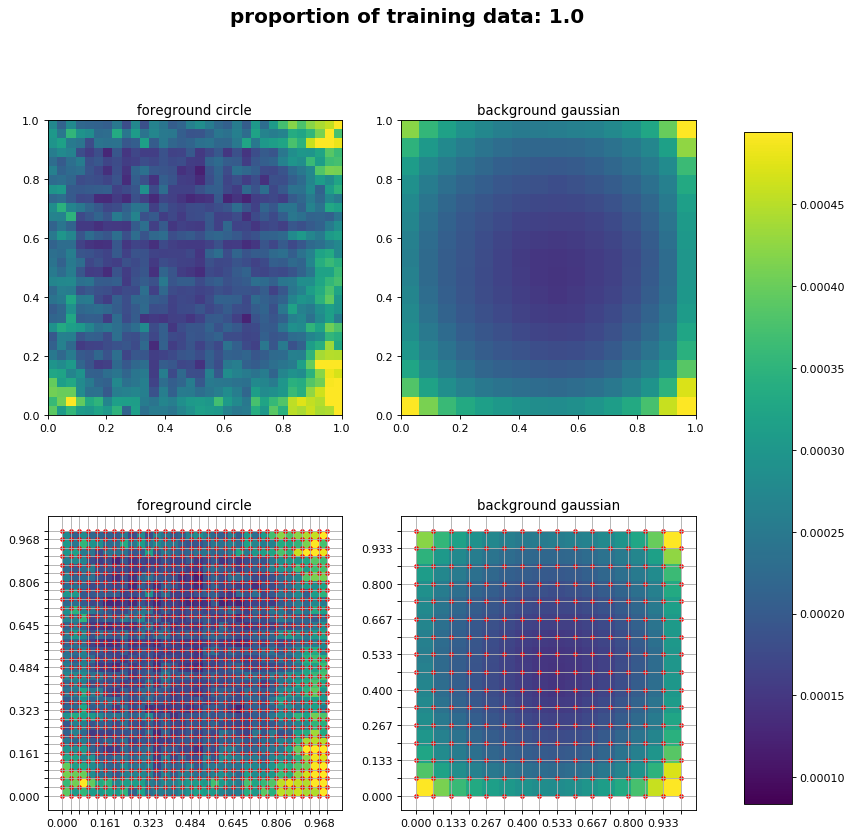

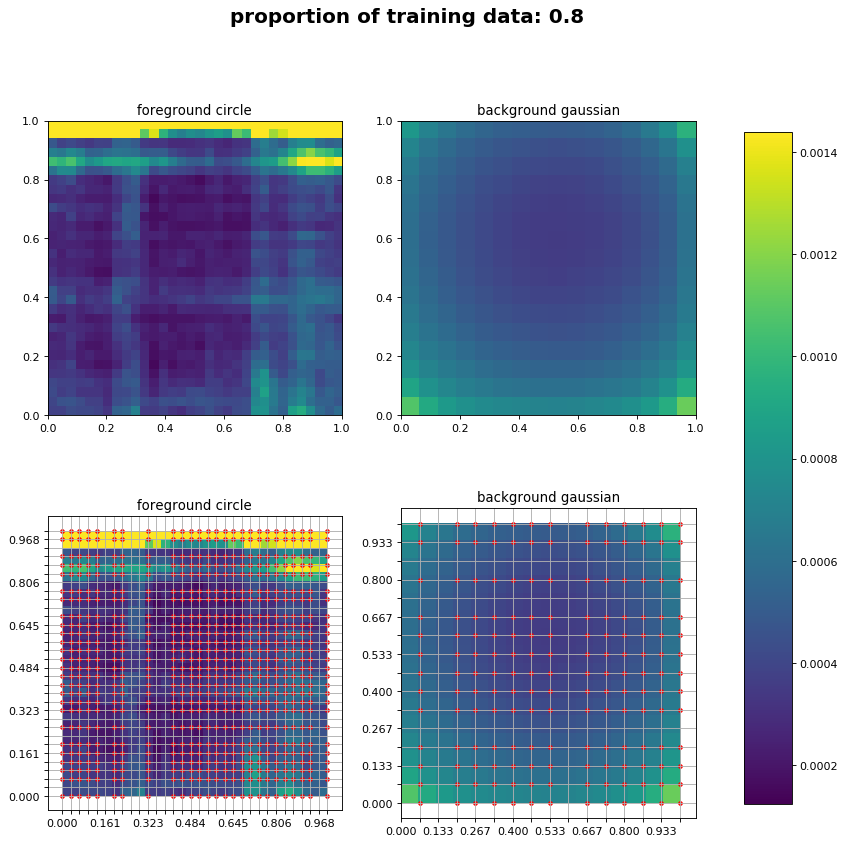

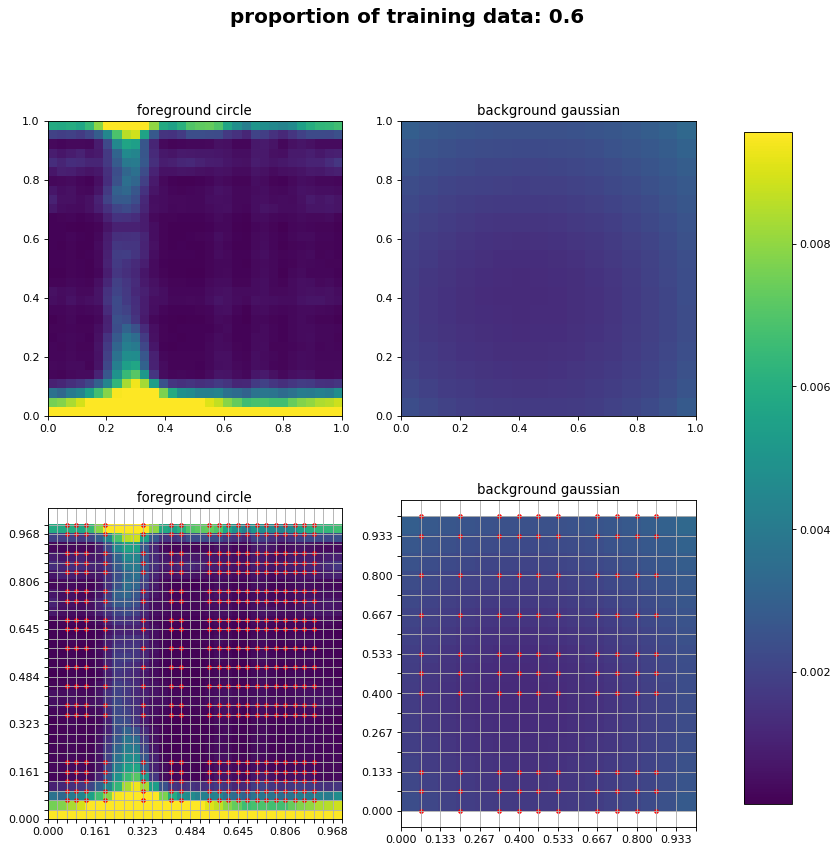

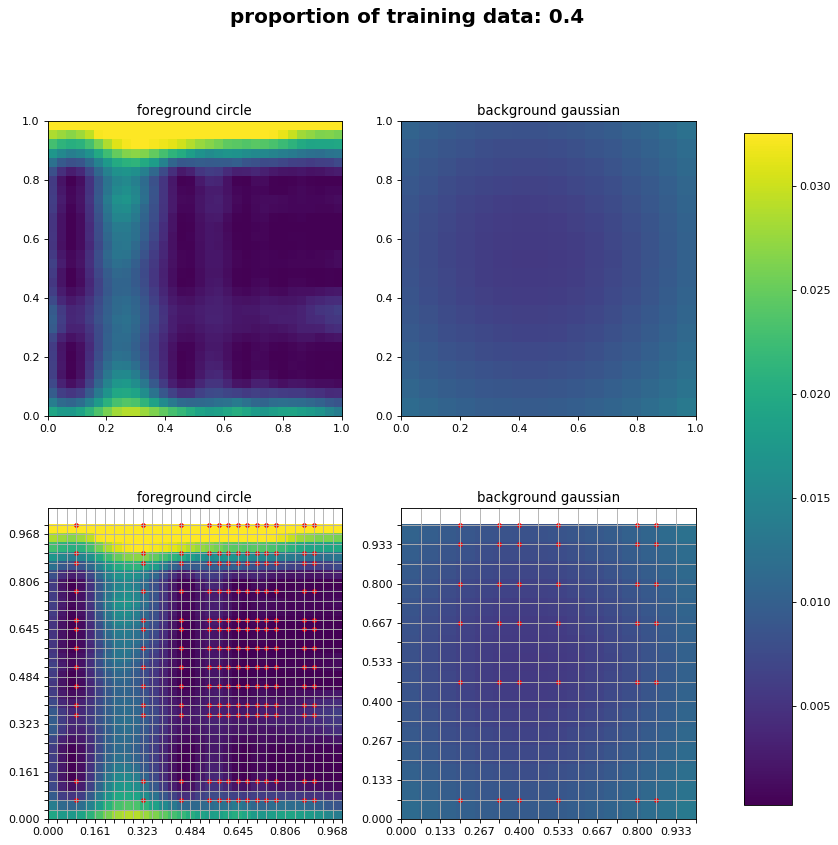

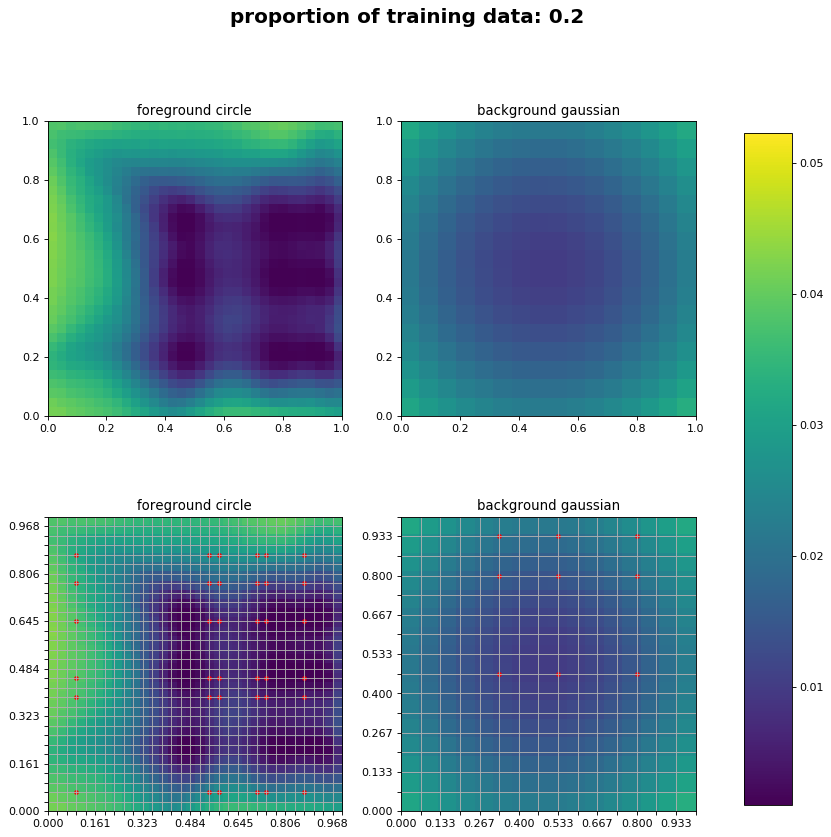

In [339]:
for ii, prop in enumerate(proportion_train_partition):
    
    lossPerGridPoint = computeOrLoadReconstructionErrorPerGridPoint(prop)
    dimVals = partition[ii]['datadimvals']
    
    fig,axes=plt.subplots(2,2,figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
    axes = axes.flatten()

    plotReconstructionLossPerGridPoint(lossPerGridPoint =lossPerGridPoint, dimVals = dimVals, axes = axes[:2])
    plotReconstructionLossPerGridPoint(lossPerGridPoint =lossPerGridPoint, dimVals = dimVals, axes = axes[2:], plt_colorbar = True)
    _ = plotSampledGridPointsForTrainingSet(partition = partition[ii], axes = axes[2:])
    
    fig.suptitle('proportion of training data: {}'.format(prop), fontsize=18, fontweight='bold')

## Sweeping across latent space

how well does reconstruction work at trained/untrained locations of the latent space?

- separate plots for foreground circle and background gaussian sweep. 
- red line shows the sweep
- colored dots correspond to reconstruction points (see color of title of reconstruction plots)


### for 100%

##### foreground circle

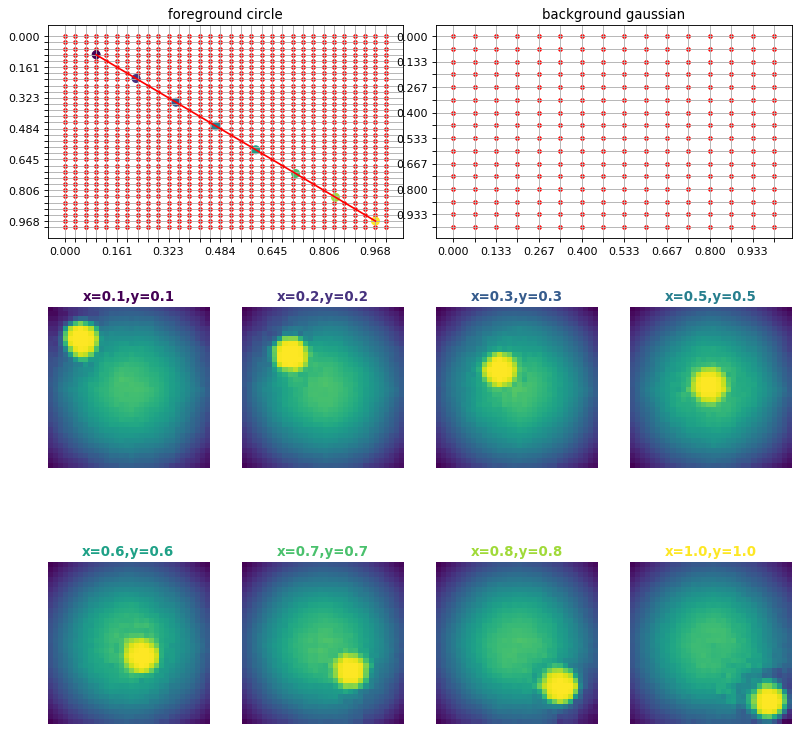

In [340]:
plotInterpolatedReconstruction(1., 'circle')

##### background gaussian

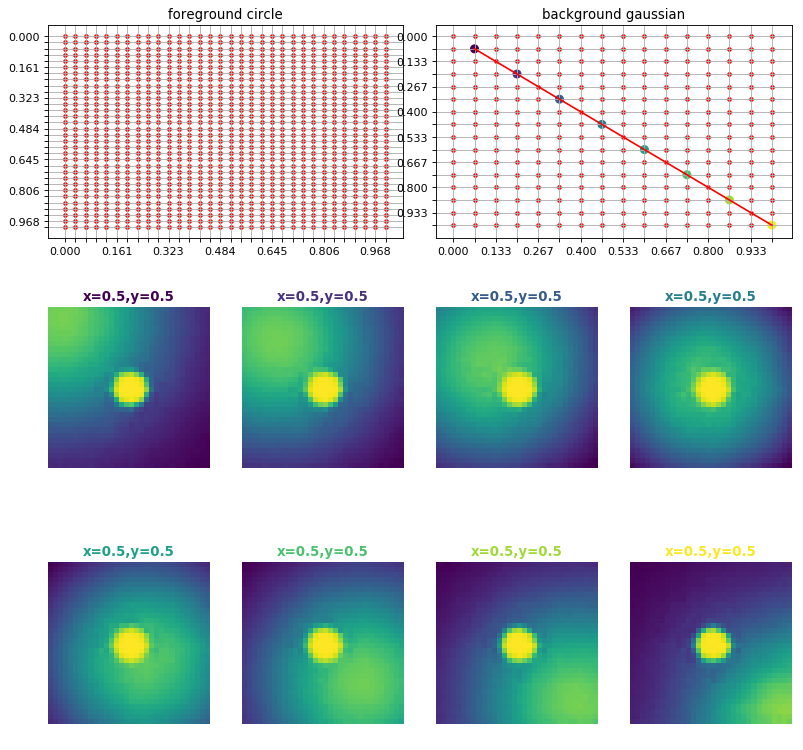

In [342]:
plotInterpolatedReconstruction(1., 'gaussian')

### for 80%

##### foreground circle

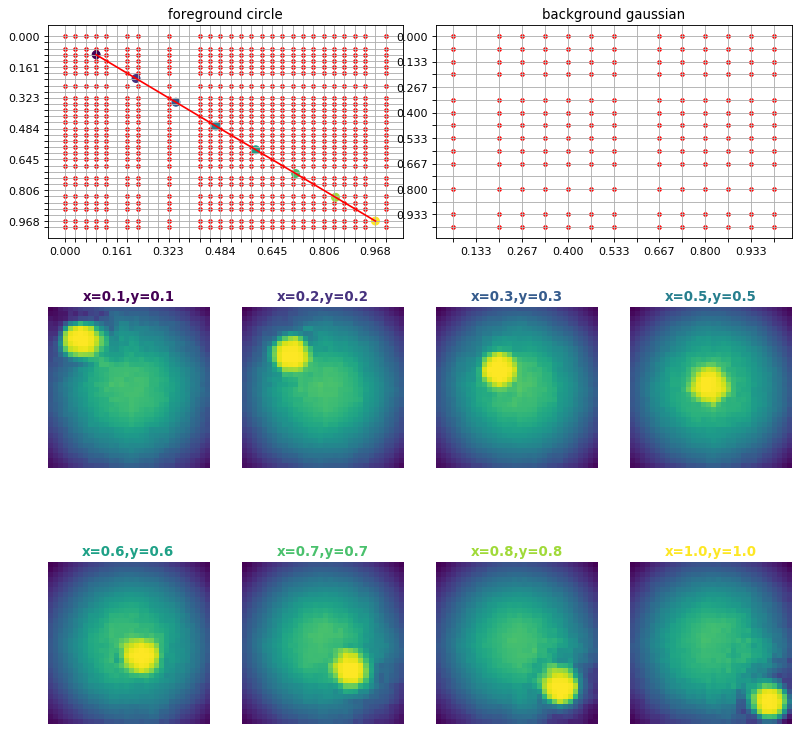

In [343]:
plotInterpolatedReconstruction(.8, 'circle')

##### background gaussian

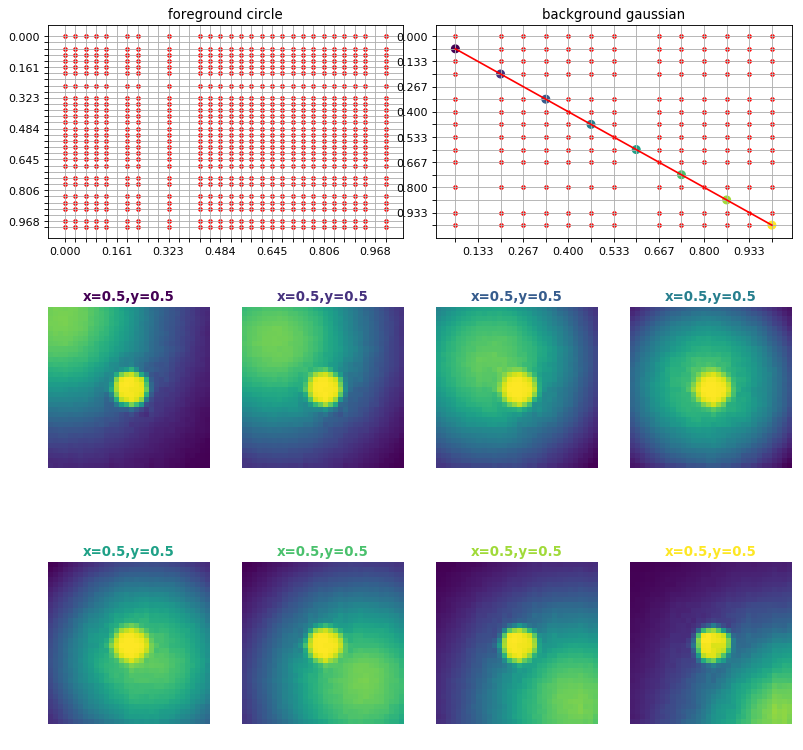

In [344]:
plotInterpolatedReconstruction(.8, 'gaussian')

### for 60%

##### foreground circle

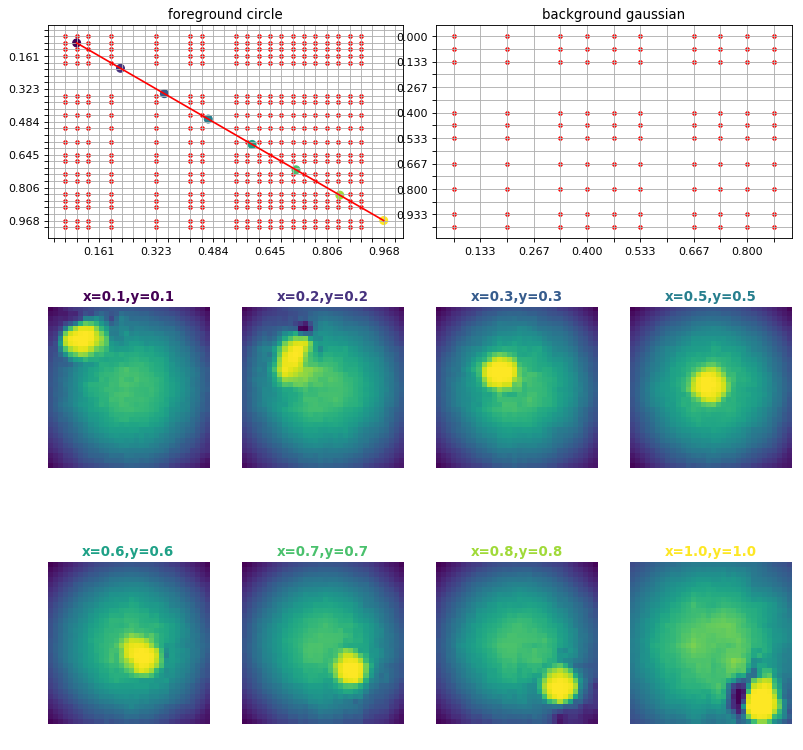

In [345]:
plotInterpolatedReconstruction(.6, 'circle')

##### background gaussian

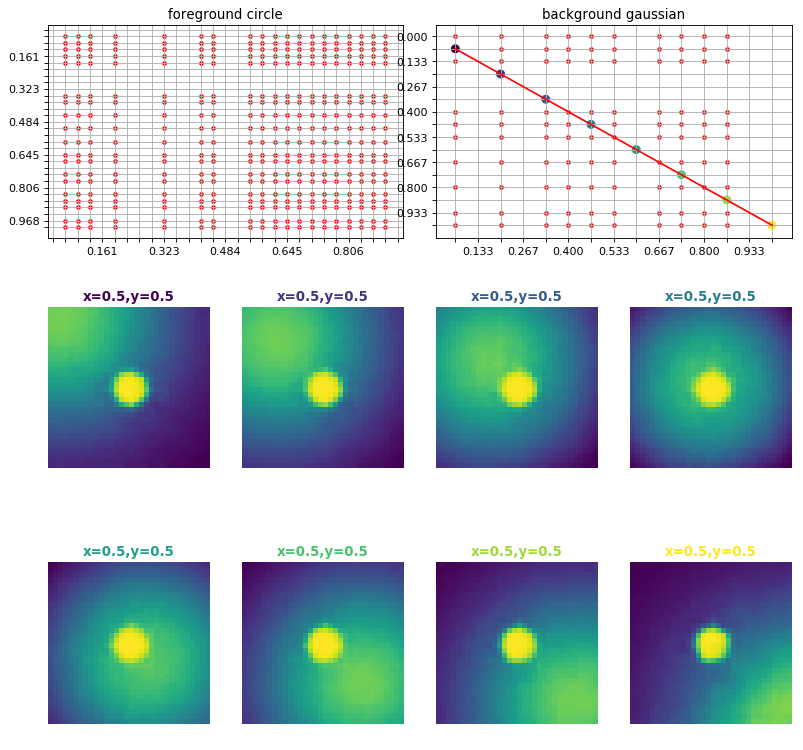

In [346]:
plotInterpolatedReconstruction(.6, 'gaussian')

### for 40%

##### foreground circle

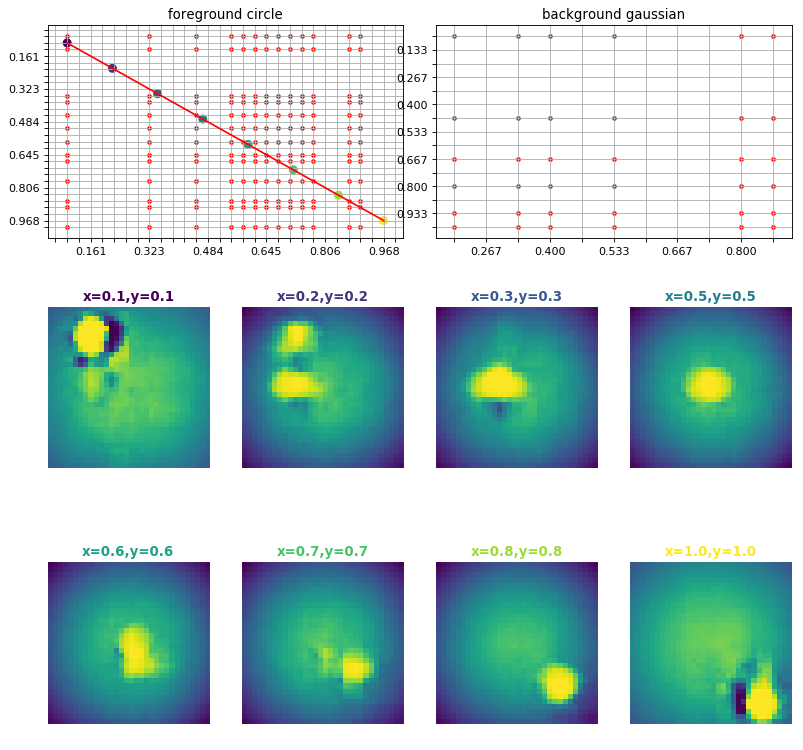

In [347]:
plotInterpolatedReconstruction(.4, 'circle')

##### background circle

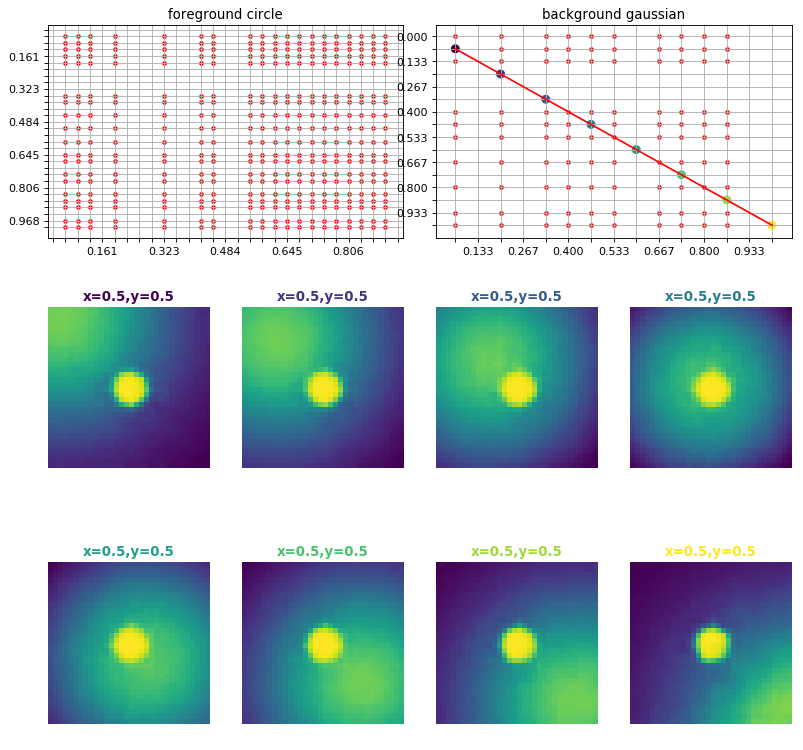

In [348]:
plotInterpolatedReconstruction(.6, 'gaussian')

### for 20%

##### foreground circle

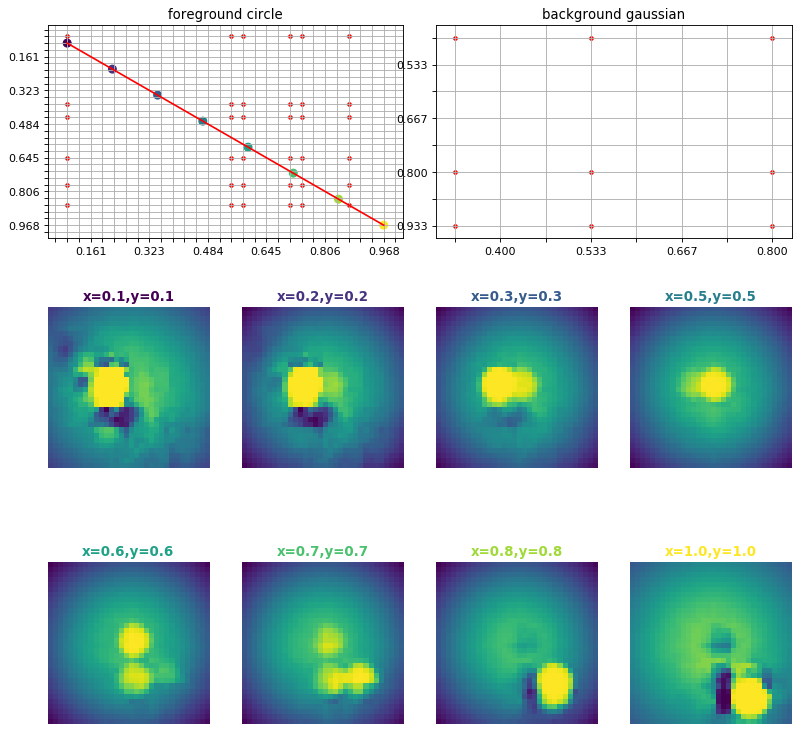

In [349]:
plotInterpolatedReconstruction(.2, 'circle')

##### background circle

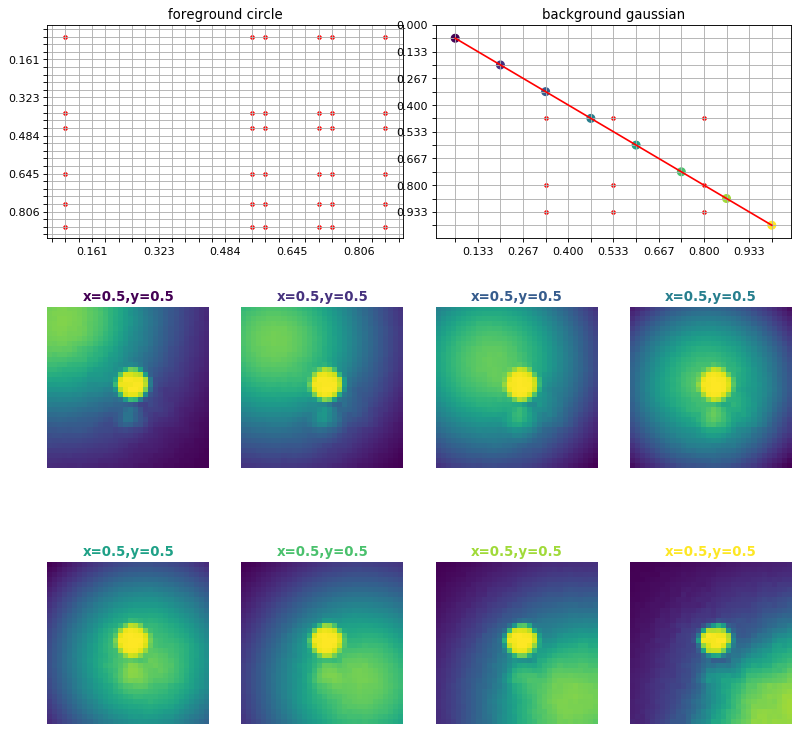

In [350]:
plotInterpolatedReconstruction(.2, 'gaussian')